# Modules for generating an ECG Synthetic signal with noise

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import math
import statistics
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import scipy.signal
import peakutils.peak
import seaborn as sns
import padasip as pa
import random

In [2]:
def powerinterference(signal,rate):
    """
    The function adds noise characterized by 50 or 60 Hz sinusoidal interference, 
    possibly accompanied by a number of harmonics.
    
    Input: signal-clean signal; rate-sampling rate of the signal.
    
    Output: signal with powerinterference added.
    
    """
    fs = rate
    length = len(signal)
    x = np.arange(length)
    y = 0.3*np.sin(2*np.pi*60 * (x/fs)) 
    signal_interference = signal + y
    
    return signal_interference

In [3]:
def emgnoise(signal):
    """
    The function generates EMG noise. It does so by adding random noise from a gaussian distribution with a 
    standard deviation of 0.05. Method used from the literature.
    
    Input: signal-the signal we want to add the noise on.
    
    Ouput: the noisy signal with EMG random noise.
    """
    
    noise = np.random.normal(5,0.05,len(signal))
    emg = signal + noise
    
    # 5 is the mean of the normal distribution you are choosing from
    # 0.05 is the standard deviation of the normal distribution
    # len(signal) is the number of elements you get in array noise
    
    return emg

In [4]:
def gen_bw_noise(ecg, fs, amplitude=0.5):
    """
    Adds baseline wandering to the input signal.

    Parameters:
      fs: Wandering frequency in Hz
      amplitude: Wandering amplitude
      ecg: Original signal
    Output: signal with band-width added
    """
    w = 2*np.pi*fs
    x=np.linspace(0,len(ecg)-1,len(ecg))
    ecg_bw = ecg + amplitude * np.sin(w*x)
    return ecg_bw


In [5]:
def gen_white_noise(ecg):
    """
    Functions which generates white noise and adds it to the signal.
    
    Inputs: ecg-original signal.
    
    Outputs: ecg with white noise.
    
    """
    mean = 0
    std = 0.05
    num_samples = len(ecg)
    white_noise = np.random.normal(mean, std, size=num_samples)
    ecg_wn = ecg + white_noise

    return ecg_wn

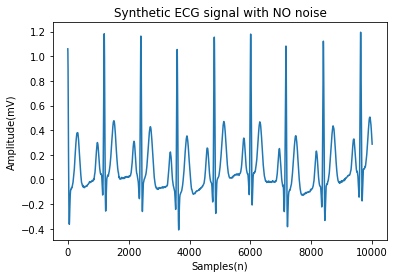

In [8]:
# We generate a clean ecg signal without noise. Sampling rate of 1000
ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
plt.plot(ecg50)
plt.title('Synthetic ECG signal with NO noise')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

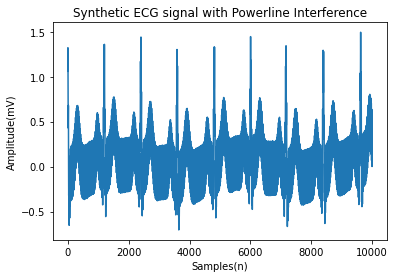

In [10]:
# 1 - We add Powerline Interference.
ecg_power = powerinterference(ecg50,1000)
plt.plot(ecg_power)
plt.title('Synthetic ECG signal with Powerline Interference')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

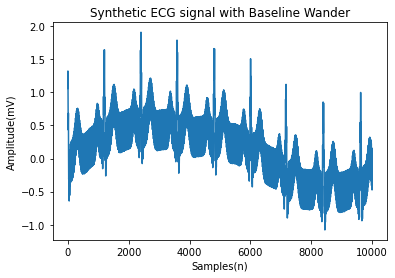

In [11]:
# 2 - We add Baseline wander.
ecg_bw = gen_bw_noise(ecg_power,0.00008)
plt.plot(ecg_bw)
plt.title('Synthetic ECG signal with Baseline Wander')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

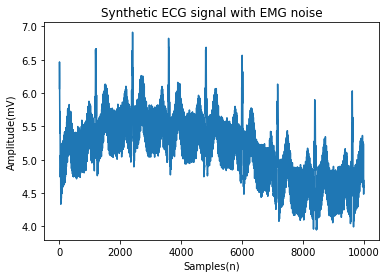

In [13]:
# 3 - We add EMG noise.
ecg_emg = emgnoise(ecg_bw)
plt.plot(ecg_emg)
plt.title('Synthetic ECG signal with EMG noise')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

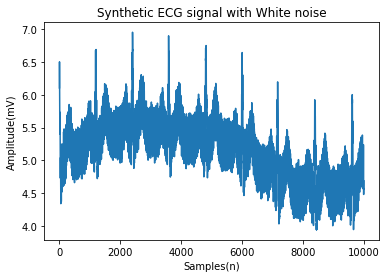

In [92]:
# 4 - We add artifact white noise.
ecg_wn = gen_white_noise(ecg_emg)
plt.plot(ecg_wn)
plt.title('Synthetic ECG signal with White noise')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

# Steps to deionise the signal: coming back to the Original.

In [15]:
def butter_lowpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a butter lowpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [16]:
def butter_highpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a highpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [17]:
def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass'):
    """
    The function filters data in the frequency domain. 
    
    Input: data-signal data stored in an array; cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; filtertype-type of filter:
        lowpass,highpass,bandpass,notch
    
    Ouput: filtered_data

    """
    
    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [18]:
def smoothing_window(signal):
    """
    The function creates a sliding window and it is used to smooth the signal out by an average mean.
    Input: signal-the signal stored in an array.
    Output: smoothened signal. 
    """
    #Define window size
    w=31
    #Define mask and store as an array
    mask=np.ones((1,w))/w
    mask=mask[0,:]

    #Convolve the mask with the raw data
    convolved_data=np.convolve(signal,mask,'same')
    return convolved_data

In [19]:
def removepowerintereference(signal,rate):
    """
    The function removes the power interference line by applying a low-pass filter at 40Hz (as recommended in the literature)
    and a smoothing window afterwards.
    
    Input: signal-noisy signal; rate-sampling rate
    
    Output: deionised signal
    """
    filtered = filter_signal(signal,40,rate)
    convolved = smoothing_window(filtered)
    
    return convolved

In [20]:
def filteremg(signal,rate):
    """
    The function removes EMG noise. EMG noise is random high-frequency noise to an average moving window filter has
    been used as a candidate to remove it. A high-pass filter is applied in cascade as well.
    
    Input: signal-the noisy signal; rate-the sampling frequency.
    
    Output: filtered signal.
    """
    
    filtered = np.convolve(signal, np.ones(50)/50, mode='valid') # We apply an average moving window to remove high-frequency noise.
    high = filter_signal(filtered,0.5, 1000, order=3, filtertype='highpass') # We apply a high-pass filter.
    
    return high
    

In [42]:
def remove_baseline_wander(ecg, sample_rate, cutoff=0.05):
    """
    The functions removes the signal's baseline.
    Input: data-signal stored in an array; sample_rate: sample rate in which the signal was sampled; cutoff-frequency frequency from which the values will be filtered out.
    Output: corrected signal.
    """
    return filter_signal(data = ecg, cutoff = cutoff, sample_rate = sample_rate,
                         filtertype='notch')


In [71]:
def remove_wn(ecg, sample_rate, cutoff=0.6):
    """
    The function removes the white noise from a signal.
    
    Input: ecg-original signal; sample_rate: the frequency at which the signal has been sampled; cutoff- cut off
    frequency for filtering.
    
    Output: signal without noise.
    
    """
    filtered = filter_signal(ecg,cutoff,sample_rate,filtertype='highpass')
    smooth = smoothing_window(notch)
    
    return smooth

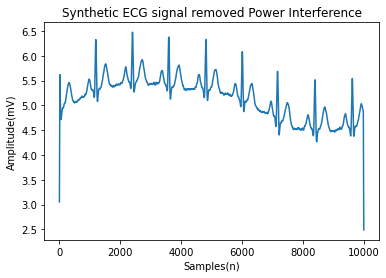

In [93]:
power = removepowerintereference(ecg_wn,1000)
plt.plot(power)
plt.title('Synthetic ECG signal removed Power Interference')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

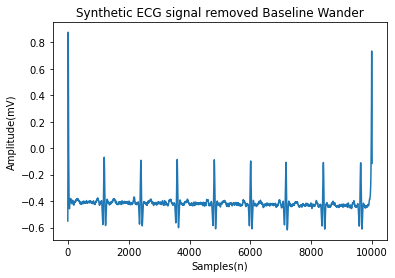

In [94]:
baseline = remove_baseline_wander(power,1000)
plt.plot(baseline)
plt.title('Synthetic ECG signal removed Baseline Wander')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

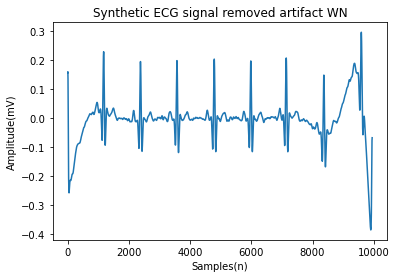

In [95]:
emg = filteremg(baseline,1000)
plt.plot(emg)
plt.title('Synthetic ECG signal removed artifact WN')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

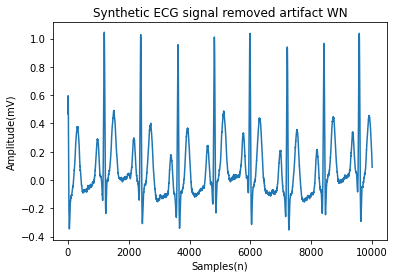

In [96]:
white_noise = remove_wn(emg,1000)
plt.plot(white_noise)
plt.title('Synthetic ECG signal removed artifact WN')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

# Additional Steps for Peak Detection

In [100]:
def scale_data(data, lower=0, upper=1024):
    """
    Subfunction from the enhance_peaks section. It allows to scale the data.
    Input: data-the signal, lower,upper-ranges that describe the scaling factor.
    Output: scaled signal. 
    """
    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

def enhance_peaks(hrdata, iterations=4):
    """
    The function squares the signal and, hence, enhances the peaks.
    Input: hrdata-the signal stored in an array; iterations-the times the signal is squared.
    Output: enhanced signal. 
    """
    scale_data(hrdata)
    for i in range(iterations):
        hrdata = np.power(hrdata, 2)
        hrdata = scale_data(hrdata)
    return hrdata 

In [101]:
def _peakdetection(signal):
    
    """
    
    The funtion detects the peaks based on a threshold algorithm described in the following paper:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7922324/. The algorithm has been tunned to incorporate a sliding threshold
    that accounts for enhanced peaks. 
    
    Input: signal-the signal we would like to obtain the peaks from.
    Output: a dataframe containing the x and y values corresponding to the different peaks detected.
    
    """
    
    peaks = pd.DataFrame()
    y_points = [] # List where we are going to store the y_values of the peaks detected.
    x_points = [] # List where we are going to store the x_values of the peaks detected.
    temp = 0.5*((0.75*np.percentile(signal, 90))+(0.25*np.mean(signal))) #+ np.std(signal) # We define the threshold.
    for index,point in enumerate(signal): 
        if point > temp: # We check if the value is bigger than the threshold. If it is the case, we set it as the new threshold.
            threshold = point
            if signal[index+1]< threshold and (signal[index]-signal[index-1]) > 0: # If the next value is lower than the threshold, then we add the point as detected and we restart the threshold.
                y_points.append(point) # We add the difference between the values because the first condition will detect all the points on the QRS complex, we need to not save the lower points on the peak's slope.
                x_points.append(index)
        if point < temp: # Once the peak is stored, we restart the threshold value to calculate the following peak.
            threshold = temp
    
    peaks['x_values'] = x_points
    peaks['y_values'] = y_points
    
    return peaks
    

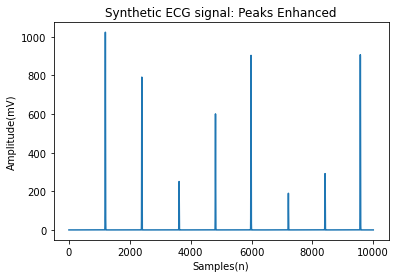

In [103]:
# 1 - Signal enhancement.
en = enhance_peaks(white_noise)
plt.plot(en)
plt.title('Synthetic ECG signal: Peaks Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

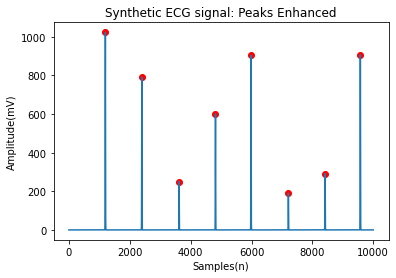

In [104]:
# 2 - Peak detection, algorithm coded from literature.
peaks = _peakdetection(en) # Peak detection Jaume's Peak Detection
plt.plot(en)
plt.title('Synthetic ECG signal: Peaks Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',c='red')
plt.show()

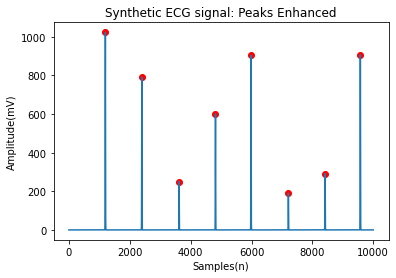

In [106]:
# 3 - Peak detection, library peakutils.

peaks_50 = peakutils.peak.indexes(np.array(en),
thres = 7.0/max(en), min_dist=2)

signal, = plt.plot(en)
plt.title('Synthetic ECG signal: Peaks Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
x_data = signal.get_xdata()
y_values = []
for point in peaks_50:
    value = np.interp(point, x_data, en)
    y_values.append(value)
plt.scatter(peaks_50,y_values,marker='o',c='red')
plt.show()